In [41]:
import pandas as pd
import numpy as np
import time

### 1. Understand the data
- Noshow=1 means patient did not come for the appointment

In [43]:
train_df = pd.read_csv("X_train_processed.csv")
test_df = pd.read_csv("X_test_processed.csv")


In [44]:
X_train_processed = train_df.drop(columns=["No-show"]).to_numpy()
y_train = train_df["No-show"].to_numpy().reshape(-1, 1)

X_test_processed = test_df.drop(columns=["No-show"]).to_numpy()
y_test = test_df["No-show"].to_numpy().reshape(-1, 1)


In [45]:
print("X_train_processed:", X_train_processed.shape)
print("y_train:", y_train.shape)
print("X_test_processed:", X_test_processed.shape)
print("y_test:", y_test.shape)


X_train_processed: (88407, 11)
y_train: (88407, 1)
X_test_processed: (22102, 11)
y_test: (22102, 1)


### 2. Architecture

In [47]:
n_features = X_train_processed.shape[1]           #input size
layer_dim = [n_features, 32, 16, 1]               # 2 hidden layers with 32 and 16 neurons, 1 output
# layer_dim = [n_features, 16, 1]


### 3. Neural network class

tried different loss function, with weights and chose where f1 score is high

In [49]:
class NeuralNetwork:
    def __init__(self, layer_dim, seed=42):
        np.random.seed(seed)
        self.layer_dim = layer_dim
        self.parameters = {}
        self.L = len(layer_dim) - 1
        for i in range(1, len(layer_dim)):
            self.parameters[f"W{i}"] = np.random.randn(layer_dim[i], layer_dim[i-1]) * np.sqrt(2. / layer_dim[i-1])
            self.parameters[f"b{i}"] = np.zeros((layer_dim[i], 1))

    def relu(self, z):
        return np.maximum(0, z)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def forward(self, X):
        A = X.T
        cache = {"A0": A}
        for i in range(1, self.L + 1):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            Z = W @ A + b
            A = self.relu(Z) if i < self.L else self.sigmoid(Z)
            cache[f"Z{i}"] = Z
            cache[f"A{i}"] = A
        return A.T, cache

    def compute_loss(self, Y_hat, Y):
        m = Y.shape[0]
        epsilon = 1e-8
        # loss = -np.mean(Y * np.log(Y_hat + epsilon) + (1 - Y) * np.log(1 - Y_hat + epsilon))
        # In your compute_loss method

        
        alpha = 1  # Adjust this experimentally
        #loss = -np.mean(alpha * y * np.log(y_hat + ε) + (1 - y) * np.log(1 - y_hat + ε))
        loss = -np.mean(alpha * Y * np.log(Y_hat + epsilon) + (1 - Y) * np.log(1 - Y_hat + epsilon))
        return loss
    # def compute_loss(self, Y_hat, Y, alpha=3):  # alpha > 1 penalizes false negatives more
    #     m = Y.shape[0]
    #     epsilon = 1e-8
    #     loss = -np.mean(alpha * Y * np.log(Y_hat + epsilon) + (1 - Y) * np.log(1 - Y_hat + epsilon))
    #     return loss


    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ

    def sigmoid_backward(self, dA, Z):
        s = self.sigmoid(Z)
        return dA * s * (1 - s)

    def backward(self, X, Y, cache):
        grads = {}
        m = X.shape[0]
        L = self.L
        A_prev = cache[f"A{L-1}"]
        ZL = cache[f"Z{L}"]
        AL = self.sigmoid(ZL)
        dZL = AL - Y.T
        grads[f"dW{L}"] = (1/m) * np.dot(dZL, A_prev.T)
        grads[f"db{L}"] = (1/m) * np.sum(dZL, axis=1, keepdims=True)
        dA_prev = np.dot(self.parameters[f"W{L}"].T, dZL)
        for i in reversed(range(1, L)):
            Z = cache[f"Z{i}"]
            A_prev = cache[f"A{i-1}"]
            dZ = self.relu_backward(dA_prev, Z)
            grads[f"dW{i}"] = (1/m) * np.dot(dZ, A_prev.T)
            grads[f"db{i}"] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = np.dot(self.parameters[f"W{i}"].T, dZ)
        return grads

    def update_params(self, grads, learning_rate):
        for l in range(1, self.L + 1):
            self.parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
            self.parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    def train(self, X, Y, epochs=100, learning_rate=0.01, verbose=True):
        for i in range(epochs):
            Y_hat, cache = self.forward(X)
            loss = self.compute_loss(Y_hat, Y)
            grads = self.backward(X, Y, cache)
            self.update_params(grads, learning_rate)
            if verbose and i % 10 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")

    def predict(self, X, threshold=0.5):
        Y_hat, _ = self.forward(X)
        return (Y_hat > threshold).astype(int)


### Training loop

In [51]:
nn = NeuralNetwork(layer_dim)
start = time.time()
nn.train(X_train_processed, y_train, epochs=1000, learning_rate=0.01)
end = time.time()
print(f"Training Time: {end - start:.2f} seconds")
import matplotlib.pyplot as plt



Epoch 0, Loss: 0.6820
Epoch 10, Loss: 0.6048
Epoch 20, Loss: 0.5682
Epoch 30, Loss: 0.5500
Epoch 40, Loss: 0.5402
Epoch 50, Loss: 0.5344
Epoch 60, Loss: 0.5305
Epoch 70, Loss: 0.5278
Epoch 80, Loss: 0.5255
Epoch 90, Loss: 0.5237
Epoch 100, Loss: 0.5220
Epoch 110, Loss: 0.5205
Epoch 120, Loss: 0.5191
Epoch 130, Loss: 0.5178
Epoch 140, Loss: 0.5166
Epoch 150, Loss: 0.5154
Epoch 160, Loss: 0.5144
Epoch 170, Loss: 0.5133
Epoch 180, Loss: 0.5123
Epoch 190, Loss: 0.5114
Epoch 200, Loss: 0.5105
Epoch 210, Loss: 0.5097
Epoch 220, Loss: 0.5089
Epoch 230, Loss: 0.5081
Epoch 240, Loss: 0.5074
Epoch 250, Loss: 0.5067
Epoch 260, Loss: 0.5060
Epoch 270, Loss: 0.5053
Epoch 280, Loss: 0.5047
Epoch 290, Loss: 0.5041
Epoch 300, Loss: 0.5035
Epoch 310, Loss: 0.5030
Epoch 320, Loss: 0.5025
Epoch 330, Loss: 0.5019
Epoch 340, Loss: 0.5014
Epoch 350, Loss: 0.5010
Epoch 360, Loss: 0.5005
Epoch 370, Loss: 0.5001
Epoch 380, Loss: 0.4996
Epoch 390, Loss: 0.4992
Epoch 400, Loss: 0.4988
Epoch 410, Loss: 0.4984
Epo

### Test -prediction

In [53]:
predictions = nn.predict(X_test_processed, threshold=0.2)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 57.80%


In [54]:
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, classification_report, f1_score

### Evaluation metrics 

In [56]:
print("Training time:",end-start)
print("Test Accuracy:", accuracy_score(y_test, predictions))
print("F1-Score:",f1_score(y_test, predictions))
print("PR-AUC: ",average_precision_score(y_test,predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

Training time: 126.49761962890625
Test Accuracy: 0.5780019907700661
F1-Score: 0.37331183229187664
PR-AUC:  0.24116488642502398
Confusion Matrix:
 [[9997 7685]
 [1642 2778]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.57      0.68     17682
           1       0.27      0.63      0.37      4420

    accuracy                           0.58     22102
   macro avg       0.56      0.60      0.53     22102
weighted avg       0.74      0.58      0.62     22102



### F1 vs threshold

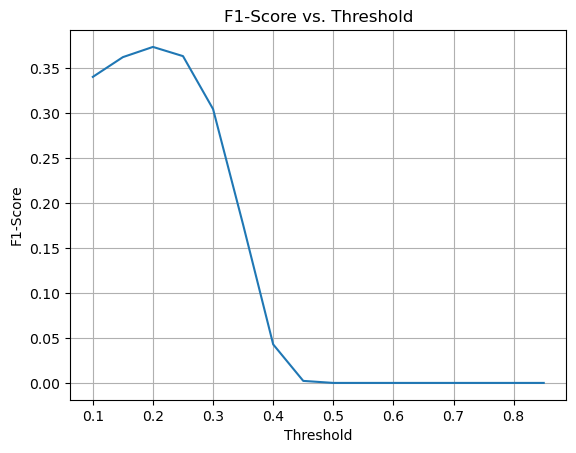

In [58]:
import matplotlib.pyplot as plt

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
y_probs, _ = nn.forward(X_test_processed)
for t in thresholds:
    predictions = (y_probs > t).astype(int)
    f1 = f1_score(y_test, predictions)
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1-Score vs. Threshold")
plt.grid()
plt.show()




In [59]:
print("Predicted Probabilities Range:")
print("Min:", np.min(y_probs))
print("Max:", np.max(y_probs))
print("Mean:", np.mean(y_probs))


Predicted Probabilities Range:
Min: 0.04455993240731837
Max: 0.4689715065340308
Mean: 0.2101961503458364
